In [76]:
from cerebralcortex import Kernel
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import pickle

pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

### Fetch data

In [2]:
with open('/home/jupyter/sneupane/MOODS/analysis/papers/CHI/dataframe/final_df.pickle', 'rb') as handle:
    final_df = pickle.load(handle).assign(date=lambda df: df['starttime'].dt.date)

In [3]:
with open('/home/jupyter/sneupane/MOODS/analysis/papers/CHI/dataframe/final_df_stressed_with_category.pickle', 'rb') as handle:
    df_with_category = pickle.load(handle)

In [4]:
with open("/home/jupyter/sneupane/MOODS/analysis/papers/NPJ/final_df_band.pickle", 'rb') as handle:
    final_df_band = pickle.load(handle)

In [5]:
stressid_mappedstressors = {x:y for x, y in zip(df_with_category['stress_id'], df_with_category['mapped_stressors'])}

### Data cleaning and filtering

In [6]:
cols = ['user', 'stress_id', 'value', 'starttime', 'endtime', 
        'episode_class', 'selected', 'user_generated', "user_rating", 
        'Stressor'] 

In [7]:
def tweak_ds_users_episodes(df_users_episodes):        
    return (df_users_episodes[cols]
            .assign(episode_class_new=lambda df_: np.where(df_['value'] > 0.11, 1, 0), 
                    date=lambda df_: df_['starttime'].dt.date, 
                    rated=lambda df_: np.where(df_["user_rating"].notnull(), 1, 0), 
                    mapped_stressors=lambda df_: df_['stress_id'].map(stressid_mappedstressors))
            .sort_values(by=['user', 'endtime'])
           )

In [8]:
def filter_df_users_episodes(df_users_episodes):
    return (df_users_episodes
            .loc[lambda df: df['endtime'].shift() != df['endtime']]
            .loc[lambda df: (df['episode_class'].isin([0, 2])) 
                 & (df['user_generated'] == 0)] 
           )

In [9]:
def user_rating_change(user_rating):
    if user_rating in ["Probably not stressed", "Not stressed"]:
        return "NotStressed"
    elif user_rating in ["Probably stressed", "Stressed"]:
        return "Stressed"
    elif user_rating == "Unsure":
        return "Unsure"
    else:
        return user_rating
    
def stressor_valid(stressor):
    if stressor in ["illegible", "unknown"]:
        return "illegible"
    elif type(stressor) == str:
        return "Valid"
    else:
        return "NA"
    
def user_rating_change_stressor(user_rating,stressor):
    if user_rating == "Stressed":
        if stressor == "Valid":
            return "Stressed with valid stressor"
        else:
            return "Stressed with invalid stressor"
    else:
        if type(user_rating) == str:
            return user_rating + " with " + stressor
        else:
            return user_rating

In [10]:
final_df = tweak_ds_users_episodes(final_df)
final_df = filter_df_users_episodes(final_df)
final_df["user_rating_change"] = final_df["user_rating"].apply(user_rating_change)
final_df["rating_with_stressor"] = final_df["mapped_stressors"].apply(stressor_valid)
final_df["user_rating_change_stressor"] = (final_df
                                         .apply(lambda x: user_rating_change_stressor(x.user_rating, 
                                                                                      x.rating_with_stressor), 
                                                axis=1))

### Take only stressed events thresholded by 0.11

In [11]:
th_based_stress_events = final_df.loc[final_df['episode_class_new'] == 1]

In [59]:
fraction_of_thesholded_events = (final_df
                                 .groupby(['user'])['episode_class_new']
                                 .agg(['sum', 'count'])
                                 .assign(fraction=lambda df_: df_['sum'] / df_['count'])
                                 .sort_values(by=['fraction']))

In [80]:
# fraction_of_thesholded_events.head()

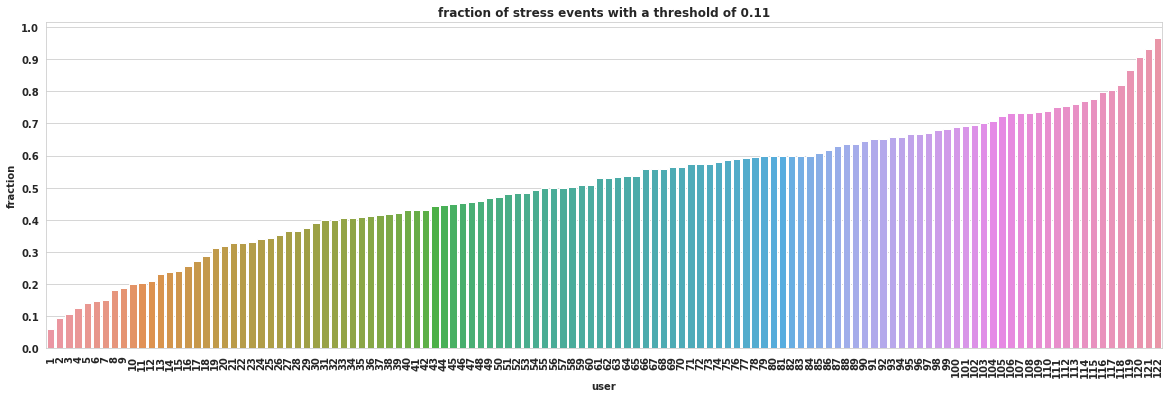

In [79]:
plt.figure(figsize=(20, 6))
sns.barplot(data=fraction_of_thesholded_events, 
            x=[str(i) for i in range(1, len(fraction_of_thesholded_events) + 1)], 
            y='fraction')
plt.xticks(rotation=90, fontweight='bold')
plt.yticks(np.arange(0, 1.1, 0.1), fontweight='bold')
plt.xlabel("user", fontweight='bold')
plt.ylabel("fraction", fontweight='bold')
plt.title("fraction of stress events with a threshold of 0.11", fontweight='bold');

In [43]:
daywise_total_stress_events =(final_df
                          .groupby(['user', 'date'])['episode_class_new']
                          .agg(['sum'])
                          .reset_index())

In [46]:
# daywise_total_stress_events.head()

In [13]:
def get_max_budget(daywise_total_stress_events, fraction):
    max_budget = np.floor(daywise_total_stress_events['sum'].mean() * fraction)
    std = np.std(daywise_total_stress_events['sum'])
    return int(max_budget), std
max_budget, std = get_max_budget(daywise_total_stress_events, 1)
print(max_budget, std)

8 8.655400001631024


### Simulate seqRTS to get prompt decision

In [14]:
from collections import defaultdict

def simulate_seqRTS(th_based_stress_events, daywise_total_stress_events, max_budget):
    stress_events_prompts = defaultdict(dict)
    for budget in range(1, max_budget + 1):
        grp_dfs = th_based_stress_events.groupby(['user', 'date'])
        for (user, date), df in grp_dfs:
            forecast = ((daywise_total_stress_events
                        .loc[(daywise_total_stress_events['user'] == user) & 
                             (daywise_total_stress_events['date'] == date), 
                             'sum'])
                        .iloc[0])
            tot_delivered = 0
            n = 1
            if budget >= forecast:
                for idx, row in df.iterrows():
                    event = row['stress_id']
                    stress_events_prompts[budget][event] = 1
            else:
                for idx, row in df.iterrows():
                    event = row['stress_id']                
                    randomization_prob = (budget - tot_delivered) / forecast
                    prompt = np.random.choice([0, 1], size=n, 
                                              p=[1-randomization_prob, randomization_prob])[0]
                    stress_events_prompts[budget][event] = prompt
                    tot_delivered += prompt
                    forecast -= 1
                
    return stress_events_prompts

In [15]:
stress_events_prompts = simulate_seqRTS(th_based_stress_events, daywise_total_stress_events, 6)

In [16]:
stress_events_prompts.keys()

dict_keys([1, 2, 3, 4, 5, 6])

In [17]:
final_df["rating_with_stressor"].value_counts()

NA           117306
Valid         10884
illegible       338
Name: rating_with_stressor, dtype: int64

### Map prompt decision to th_based_stress_events

In [18]:
def assign_prompt_decision(th_based_stress_events, stress_events_prompts):
    for key in stress_events_prompts.keys():
        new_col = 'budget_' + str(key)
        th_based_stress_events[new_col] = th_based_stress_events['stress_id'].map(stress_events_prompts[key])
    return th_based_stress_events

In [19]:
th_based_stress_events = assign_prompt_decision(th_based_stress_events,
                                                stress_events_prompts)

In [45]:
# th_based_stress_events.head()

### Produce summary result of each day with no observations and valid stressor status for budget between 1 to 6

In [21]:
def budget_observations_validstressors(th_based_stress_events, max_budget):
    bgt_summary = []
    for budget in range(1, max_budget + 1):
        req_col = "budget_" + str(budget)
        prompted_df = th_based_stress_events.loc[th_based_stress_events[req_col] == 1]
        grp_dfs = prompted_df.groupby(['user', 'date'])
        for (user, date), df in grp_dfs:
            no_observation = (df['rated'] == 0).sum()
            valid_stressors = (df["rating_with_stressor"] == 'Valid').sum()
            bgt_summary.append([user, date, budget, no_observation, valid_stressors])
    return pd.DataFrame(bgt_summary, columns=['user', 'date', 'budget', 'no_observation', 'valid_stressor'])

In [22]:
result_1 = budget_observations_validstressors(th_based_stress_events, 6)

In [47]:
# result_1.head()

In [24]:
result_1['budget'].value_counts()

6    7005
5    7005
4    7005
3    7005
2    7005
1    7005
Name: budget, dtype: int64

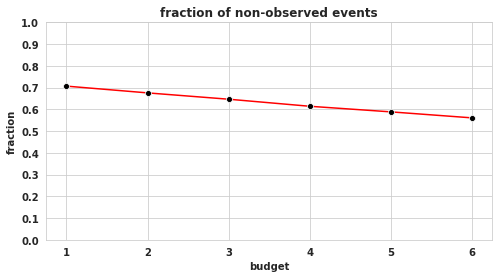

In [87]:
data = (result_1
        .groupby(['budget'])['no_observation']
        .agg(['sum', 'count'])
        .reset_index()
        .assign(prompted=lambda df_: df_['budget'] * df_['count'], 
                fraction=lambda df_: df_['sum'] / df_['prompted']))
plt.figure(figsize=(8, 4))
sns.lineplot(data=data, 
             x='budget', 
             y='fraction', 
             color='red', 
             marker='o', 
             markerfacecolor='black')
plt.xticks(fontweight='bold')
plt.yticks(np.arange(0, 1.1, 0.1), fontweight='bold')
plt.xlabel("budget", fontweight='bold')
plt.ylabel("fraction", fontweight='bold')
plt.title("fraction of non-observed events", fontweight='bold');

In [25]:
def map_notobserved_nostressor(budget, no_observation, valid_stressor):
    return -1 if budget == no_observation else valid_stressor

result_1['valid_stressor'] = result_1.apply(lambda df: map_notobserved_nostressor(df['budget'], 
                                            df['no_observation'], 
                                            df['valid_stressor']), 
                                            axis=1)

In [48]:
# result_1.head(5)

### Normalize the stressor likelihoods; because our sampling was biased towards higher stress intensity when picking episodes for prompting, placing the prompted episodes into 10 percentile bands and then taking the mean of fraction of valid streesors across all these 10 bands removes the bias. 

In [28]:
from collections import defaultdict
def normalized_one_stressor_likelihood(stress_events_prompts, th_based_stress_events, final_df_band):
    normalized_one_stressor_likelihood = defaultdict(dict)
    
    for budget in stress_events_prompts.keys():
        df_stress_id_prompt_status = (pd.DataFrame({'stress_id':list(stress_events_prompts[budget]
                                                                    .keys()), 
                                                  'prompt_status':list(stress_events_prompts[budget]
                                                                       .values())})
                                      .merge(th_based_stress_events[['stress_id',
                                                                     'rated', 
                                                                     'rating_with_stressor']],
                                                           on='stress_id',how='inner')
                                      .merge(final_df_band[['stress_id', 
                                                            "band_ten"]], 
                                             on='stress_id',
                                             how='inner')
                                      .assign(band_ten=lambda df_: df_["band_ten"]
                                                  .astype(int)))
        
        result = (df_stress_id_prompt_status
                  .loc[(df_stress_id_prompt_status['prompt_status'] == 1) & 
                       (df_stress_id_prompt_status['rated'] == 1)]
                  .groupby('band_ten')['rating_with_stressor']
                  .value_counts(normalize=True)
                  .unstack()
                  .fillna(0)
                  .sort_values(by=['band_ten']))
        
        for band in range(10, 110, 10):
            if band in result.index.to_list():
                normalized_one_stressor_likelihood[budget][band] = result.loc[band, 'Valid']
        normalized_one_stressor_likelihood[budget]['average'] = result['Valid'].mean()
        print(budget)        
        print(result)
        print("*"*80)
    return normalized_one_stressor_likelihood   

In [29]:
normalized_one_stressor_likelihood = normalized_one_stressor_likelihood(stress_events_prompts, 
                                                                        th_based_stress_events, 
                                                                        final_df_band)

1
rating_with_stressor    NA  Valid  illegible
band_ten                                    
20                   1.000  0.000      0.000
30                   1.000  0.000      0.000
40                   0.781  0.219      0.000
50                   0.762  0.238      0.000
60                   0.660  0.333      0.007
70                   0.628  0.360      0.012
80                   0.537  0.453      0.010
90                   0.503  0.479      0.018
100                  0.400  0.577      0.022
********************************************************************************
2
rating_with_stressor    NA  Valid  illegible
band_ten                                    
10                   1.000  0.000      0.000
20                   1.000  0.000      0.000
30                   0.857  0.143      0.000
40                   0.679  0.321      0.000
50                   0.733  0.237      0.030
60                   0.610  0.377      0.013
70                   0.618  0.376      0.006
80             

In [30]:
normalized_one_stressor_likelihood

defaultdict(dict,
            {1: {20: 0.0,
              30: 0.0,
              40: 0.21875,
              50: 0.23809523809523808,
              60: 0.3333333333333333,
              70: 0.36046511627906974,
              80: 0.45307443365695793,
              90: 0.4786184210526316,
              100: 0.5774058577405857,
              'average': 0.2955269333508685},
             2: {10: 0.0,
              20: 0.0,
              30: 0.14285714285714285,
              40: 0.32142857142857145,
              50: 0.23703703703703705,
              60: 0.3771186440677966,
              70: 0.37577639751552794,
              80: 0.45032051282051283,
              90: 0.4877606527651859,
              100: 0.5773353751914242,
              'average': 0.2969634333683199},
             3: {10: 0.0,
              20: 0.5,
              30: 0.21052631578947367,
              40: 0.3048780487804878,
              50: 0.18562874251497005,
              60: 0.321875,
              70: 0.3862660944

In [88]:
df_budgets = pd.DataFrame()
for budget in normalized_one_stressor_likelihood.keys():
    df = (pd.DataFrame({'percentile' : list(normalized_one_stressor_likelihood[budget].keys()), 
                       'stressor_lh' : list(normalized_one_stressor_likelihood[budget].values())})
          .assign(budget=budget))
    df_budgets = pd.concat([df_budgets, df])

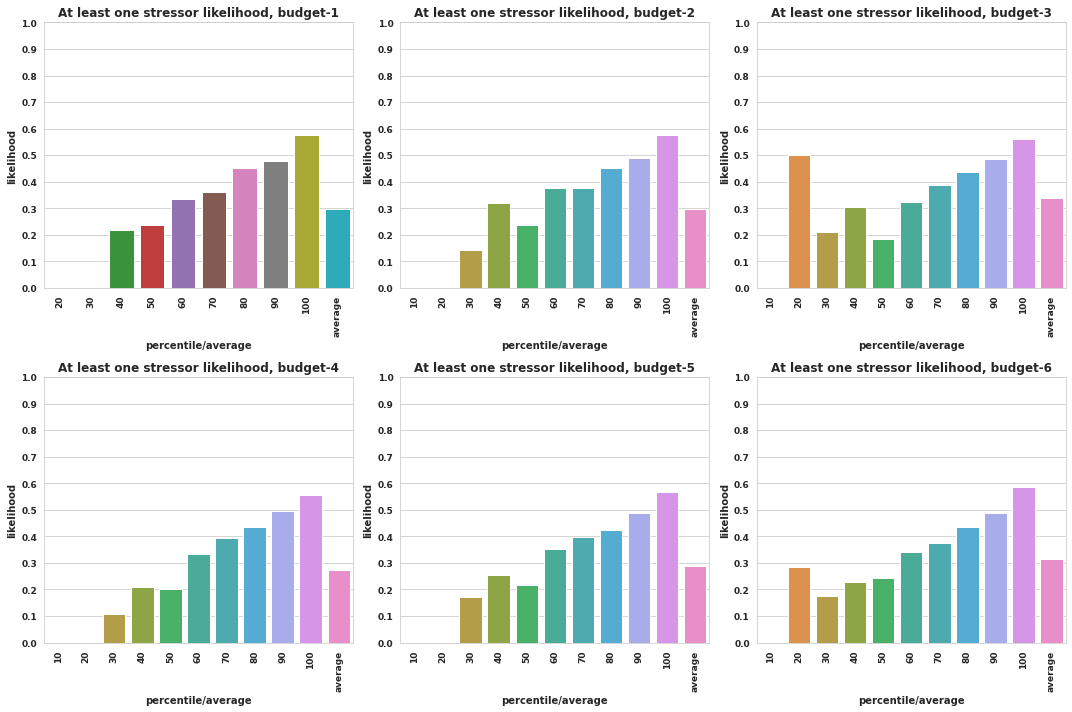

In [138]:
nrows = 2
ncols = int(np.ceil(df_budgets['budget'].max() / nrows))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=False, figsize=(ncols*5, nrows*5 ))
r, c = 0, 0
for budget in df_budgets['budget'].unique():
    data = df_budgets.loc[df_budgets['budget'] == budget]
    sns.barplot(data=data, 
                x=[str(p) for p in data['percentile'].to_list()], 
                y='stressor_lh', ax=axes[r][c])
    axes[r][c].set_title(f"At least one stressor likelihood, budget-{budget}", fontweight='bold')
    axes[r][c].set_xlabel("percentile/average", fontweight='bold')
    axes[r][c].set_ylabel("likelihood", fontweight='bold')
    xticks = data['percentile'].index
    xticklabels = data['percentile'].to_list()
    axes[r][c].set_xticks(xticks)
    axes[r][c].set_xticklabels(xticklabels,                                      
                               rotation=90, 
                               fontsize=9, 
                               fontweight='bold'
                              )
    yticks = np.arange(0, 1.1, 0.1)
    yticklabels = [str(np.round(tick, 2)) for tick in yticks]
    axes[r][c].set_yticks(yticks)
    axes[r][c].set_yticklabels(yticklabels,                                       
                               fontsize=9, 
                               fontweight='bold'
                              )                             
    c += 1
    if c == ncols:
        r += 1
        c = 0
fig.tight_layout()    

### Sanity check when any of the 10 bands have no observations

In [38]:
# pick budget = 1
check_status = (pd.DataFrame({'stress_id':list(stress_events_prompts[1]
                                                                    .keys()), 
                                                  'prompt_status':list(stress_events_prompts[1]
                                                                       .values())})
                                      .merge(th_based_stress_events[['stress_id',
                                                                     'rated', 
                                                                     'rating_with_stressor']],
                                                           on='stress_id',how='inner')
                                      .merge(final_df_band[['stress_id', 
                                                            "band_ten"]], 
                                             on='stress_id',
                                             how='inner')
                                      .assign(band_ten=lambda df_: df_["band_ten"]
                                                  .astype(int)))

In [42]:
# for any missing band from the 10 bands, there should be no stress id which was both prompted and annotated
# i.e. no observation was recorded in this band for this budget 
check_status.loc[(check_status['band_ten'] == 10) & 
                 (check_status['prompt_status'] == 1) & 
                 (check_status['rated'] == 1)]

,stress_id,prompt_status,rated,rating_with_stressor,band_ten


### Sanity check budget vs prompt status (prompt <= budget)

In [50]:
b4 = th_based_stress_events.loc[th_based_stress_events['budget_4'] == 1]
b4_total_prompts = b4.groupby(['user', 'date'])['budget_4'].agg('sum').reset_index(name='prompted')

In [51]:
# b4_total_prompts

In [32]:
b4_total_prompts["prompted"].min(), b4_total_prompts["prompted"].max()

(1, 4)

### Sanity check the Bernoulli distribution simulated by np.random.choice

In [33]:
def validation(pos):
    res = []
    for i in range(500):
        num = np.random.choice([0, 1], size=1,  p=[1-pos, pos])[0]
        res.append(num)
    return res

In [34]:
for pos in np.arange(0, 1.1, 0.1):
    print(f"probablity of success: {pos}")
    for trial in range(1, 11):
        res = validation(pos)
        print(res.count(0)/len(res), res.count(1)/len(res))
    print("-" * 80)

probablity of success: 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
--------------------------------------------------------------------------------
probablity of success: 0.1
0.898 0.102
0.884 0.116
0.92 0.08
0.916 0.084
0.894 0.106
0.892 0.108
0.904 0.096
0.916 0.084
0.918 0.082
0.898 0.102
--------------------------------------------------------------------------------
probablity of success: 0.2
0.822 0.178
0.8 0.2
0.768 0.232
0.782 0.218
0.826 0.174
0.804 0.196
0.818 0.182
0.8 0.2
0.814 0.186
0.836 0.164
--------------------------------------------------------------------------------
probablity of success: 0.30000000000000004
0.714 0.286
0.688 0.312
0.702 0.298
0.716 0.284
0.71 0.29
0.724 0.276
0.72 0.28
0.718 0.282
0.712 0.288
0.732 0.268
--------------------------------------------------------------------------------
probablity of success: 0.4
0.578 0.422
0.562 0.438
0.598 0.402
0.606 0.394
0.638 0.362
0.626 0.374
0.61 0.39
0.618 0.382
0.6 0

### Sanity check stresssor likelihood of 75th percentile

In [52]:
# final_df_band.head(2)

In [53]:
final_df_band = final_df_band.assign(rated=lambda df_: np.where(df_['user_rating'].notnull(), 1, 0), 
                                     date=lambda df_: df_['starttime'].dt.date, 
                                     top_75=lambda df_: df_['top_75'].astype(int))
top_75th_daywise_annot_count = (final_df_band
                                .loc[final_df_band['top_75'] == 1]
                                .groupby(['user', 'date'])['rated']
                                .agg('sum')
                                .reset_index(name='annot_count'))

In [55]:
# top_75th_daywise_annot_count.head()

In [37]:
for budget in range(1, 7):
    budget_df_75th = (top_75th_daywise_annot_count.loc[top_75th_daywise_annot_count['annot_count'] == budget, 
                                                    ['user', 'date']])
    if len(budget_df_75th):
        total_annot = len(budget_df_75th) * budget
        
        valid_stressors = 0
        for idx, row in budget_df_75th.iterrows():
            stressors = th_based_stress_events.loc[(th_based_stress_events['user'] == row['user']) & 
                                                   (th_based_stress_events['date'] == row['date']) & 
                                                   (th_based_stress_events['rating_with_stressor'] == 'Valid')]
            if len(stressors):
                valid_stressors += len(stressors)
                                             
        valid_stressor_ratio = valid_stressors / total_annot
        print(budget, valid_stressor_ratio )

1 0.7693561532192339
2 0.6478426395939086
3 0.6898932831136221
4 0.5732558139534883
5 0.5874538745387454
6 0.6148648648648649
